In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import files


In [9]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("cleaned_burnout_dataset.csv")
print(df.head())

Saving cleaned_burnout_dataset.csv to cleaned_burnout_dataset (1).csv
   EmployeeID  Age      Gender    Country            JobRole Department  \
0        1001   50        Male         UK    Sales Associate         HR   
1        1002   36        Male    Germany  Software Engineer         IT   
2        1003   29  Non-binary      India           IT Admin         IT   
3        1004   42        Male  Australia      HR Specialist         IT   
4        1005   40        Male     Brazil   Customer Support    Support   

   YearsAtCompany  WorkHoursPerWeek RemoteWork  BurnoutLevel  ...  \
0              14                47         No          3.37  ...   
1               1                59     Hybrid          7.39  ...   
2              13                59     Hybrid          7.10  ...   
3              15                31        Yes          4.18  ...   
4               6                34        Yes          8.28  ...   

   CommuteTime  HasMentalHealthSupport  ManagerSupportScore  Has

In [11]:

X = df.drop("BurnoutRisk", axis=1)
y = df["BurnoutRisk"]
#Convert string columns to numeric
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=69)

In [13]:
category_cols = X_train.select_dtypes(include="object").columns
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoder.fit(X_train[category_cols])

X_train_cat = pd.DataFrame(encoder.transform(X_train[category_cols]),columns=encoder.get_feature_names_out(category_cols),index=X_train.index)

X_test_cat = pd.DataFrame(encoder.transform(X_test[category_cols]),columns=encoder.get_feature_names_out(category_cols),index=X_test.index)

In [16]:
# Handling numerical columns
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

# Combine encoded and numeric features
X_train_final = pd.concat([X_train_cat, X_train_num], axis=1)
X_test_final = pd.concat([X_test_cat, X_test_num], axis=1)

# Scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_final),columns=X_train_final.columns, index=X_train_final.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_final),columns=X_test_final.columns, index=X_test_final.index)

In [17]:
# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Feature importance
feat_imp = pd.Series(rf_model.feature_importances_, index=X_train_scaled.columns)
top_3_features = feat_imp.sort_values(ascending=False).head(3).index.tolist()

print("Top 3 features:", top_3_features)

Top 3 features: ['BurnoutLevel', 'ProductivityScore', 'EmployeeID']


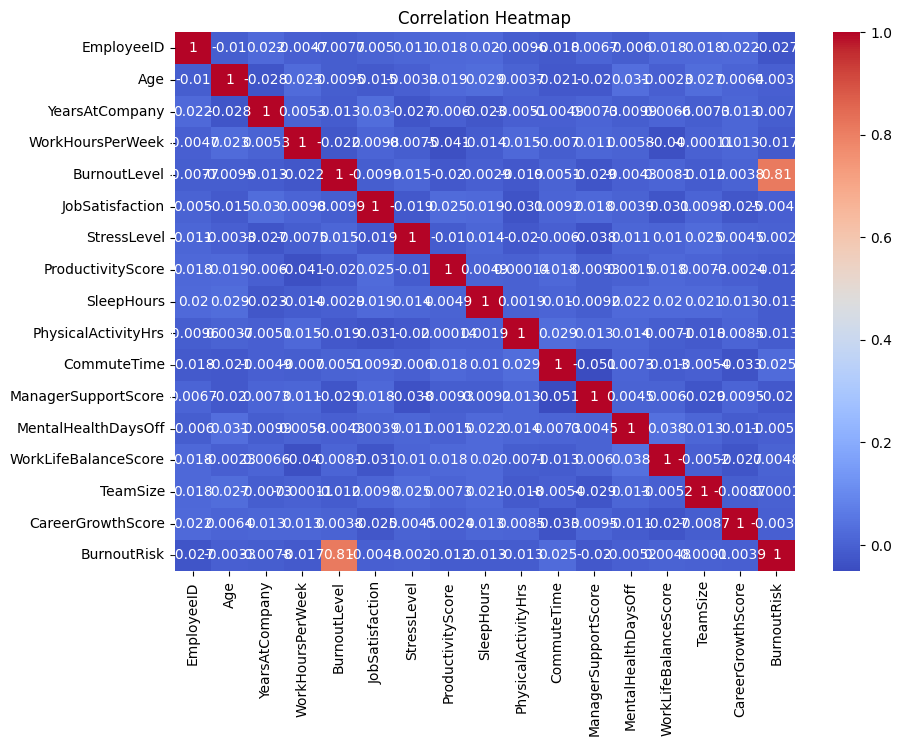

In [18]:
# correlation Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df.select_dtypes(include=["int64", "float64"]).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [22]:
# Minimal model using only top 3 features
X_train_min = X_train_scaled[top_3_features]
X_test_min = X_test_scaled[top_3_features]

rf_minimal = RandomForestClassifier(random_state=42)
rf_minimal.fit(X_train_min, y_train)
y_pred_min = rf_minimal.predict(X_test_min)

# Evaluation
acc = accuracy_score(y_test, y_pred_min)
conf = confusion_matrix(y_test, y_pred_min)

print(f"Minimal Model Accuracy: {acc:.2f}")
print("Confusion Matrix:")
print("",conf)

Minimal Model Accuracy: 1.00
Confusion Matrix:
 [[408   0]
 [  1 191]]


These features align both statistically (via feature importance) and psychologically (via burnout theory) with burnout causes. Their predictive power is evident from the model’s perfect performance. Thus these are the top 3 features for burnout risk

